In [0]:
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image
import scipy.stats as stats
from sklearn.model_selection import train_test_split
%matplotlib inline


In [0]:
train_df = pd.read_csv('house_price_train.csv')
test_df = pd.read_csv('house_price_test.csv')

# Correlation analysis

In [88]:
train_df.corr()['price'].sort_values()

zipcode         -0.044555
id              -0.014968
long             0.011760
yr_built         0.040336
condition        0.047331
sqft_lot15       0.077641
sqft_lot         0.085830
yr_renovated     0.135626
waterfront       0.268705
floors           0.278863
bedrooms         0.302262
lat              0.309542
sqft_basement    0.321816
view             0.400164
bathrooms        0.523939
sqft_living15    0.595720
sqft_above       0.604982
grade            0.665403
sqft_living      0.701237
price            1.000000
Name: price, dtype: float64

We can find the `sqft_living` `grade` and `sqft_above` have strong correlations with price.


So, I think sqft_living, grade, sqft_above will be useful for price prediction intuitively.

In [89]:
train_df.isnull().sum()

id               0
date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64

In [90]:
train_df.dtypes

id                 int64
date              object
price            float64
bedrooms           int64
bathrooms        float64
sqft_living        int64
sqft_lot           int64
floors           float64
waterfront         int64
view               int64
condition          int64
grade              int64
sqft_above         int64
sqft_basement      int64
yr_built           int64
yr_renovated       int64
zipcode            int64
lat              float64
long             float64
sqft_living15      int64
sqft_lot15         int64
dtype: object

# Feature transformation

date is string type so we convert it to numerica by 
1. Keeping 6 characters (Year Month)
2. Use LabelEncoder to convert categorical to numerical


In [0]:
def convert_to_date(date_string: str):
    """
    Only keep year and month 
    """
    # date = date_string[:8]
    # return pd.to_datetime(date, format='%Y%m%d', errors='ignore')
    return date_string[:6]

In [0]:
train_df.date = train_df.date.apply(convert_to_date)
test_df.date = test_df.date.apply(convert_to_date)

In [0]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

train_df.date = label_encoder.fit_transform(train_df.date)
test_df.date = label_encoder.fit_transform(test_df.date)


In [0]:
y_train_df = train_df.price
y_test_df = test_df.price

X_train_df = train_df.drop(['id', 'price'], axis=1)
X_test_df = test_df.drop(['id', 'price'], axis=1)


In [0]:
y_train = y_train_df.values
y_test = y_test_df.values

X_train = train_df.values
X_test = test_df.values

# Feature selection


## Removing features with low variance

It removes all features whose variance doesn’t meet some threshold.

In [0]:

from sklearn.feature_selection import VarianceThreshold

def variance_threshold_selector(train_df, test_df, threshold=0.1):
    selector = VarianceThreshold(threshold)
    selector.fit(train_df)
    transformed_train = train_df[train_df.columns[selector.get_support(indices=True)]]
    transformed_test = test_df[test_df.columns[selector.get_support(indices=True)]]
    return transformed_train, transformed_test

In [97]:
"""
X_train_df, X_test_df = variance_threshold_selector(X_train_df, X_test_df)
X_train_df.shape
"""

'\nX_train_df, X_test_df = variance_threshold_selector(X_train_df, X_test_df)\nX_train_df.shape\n'

After removing features with low variance, we have 16 columns


But based on my experiments, selecting columns in this way will decrease performance.
So I comment them here.

## Tree-based feature selection


First, we do xgboost, random forest, gbm on un-selected features.

Then, we can perform a tree-based feature selection.

For now, I just skip this method.

In [0]:
from sklearn.feature_selection import SelectFromModel

# Normlize columns

Because value range of some columns are very big. This could dominate the train process.

We normalize them by MinMaxScaler



After several experiements, I find normlize all columns decrease the performance!

In [99]:
"""
from sklearn import preprocessing

# Create a minimum and maximum processor object
min_max_scaler = preprocessing.MinMaxScaler()

# Create an object to transform the data to fit minmax processor
X_train_df[X_train_df.columns] = min_max_scaler.fit_transform(X_train_df.values)
X_test_df[X_test_df.columns] = min_max_scaler.fit_transform(X_test_df.values)
"""

'\nfrom sklearn import preprocessing\n\n# Create a minimum and maximum processor object\nmin_max_scaler = preprocessing.MinMaxScaler()\n\n# Create an object to transform the data to fit minmax processor\nX_train_df[X_train_df.columns] = min_max_scaler.fit_transform(X_train_df.values)\nX_test_df[X_test_df.columns] = min_max_scaler.fit_transform(X_test_df.values)\n'

Normalization of columns also decreases the performance based on my experiments.
So I comment them here.

In [100]:
X_train_df.head()

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,5,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,7,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,9,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,7,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,9,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


# Distribution of price

Let's see the distribution of house price

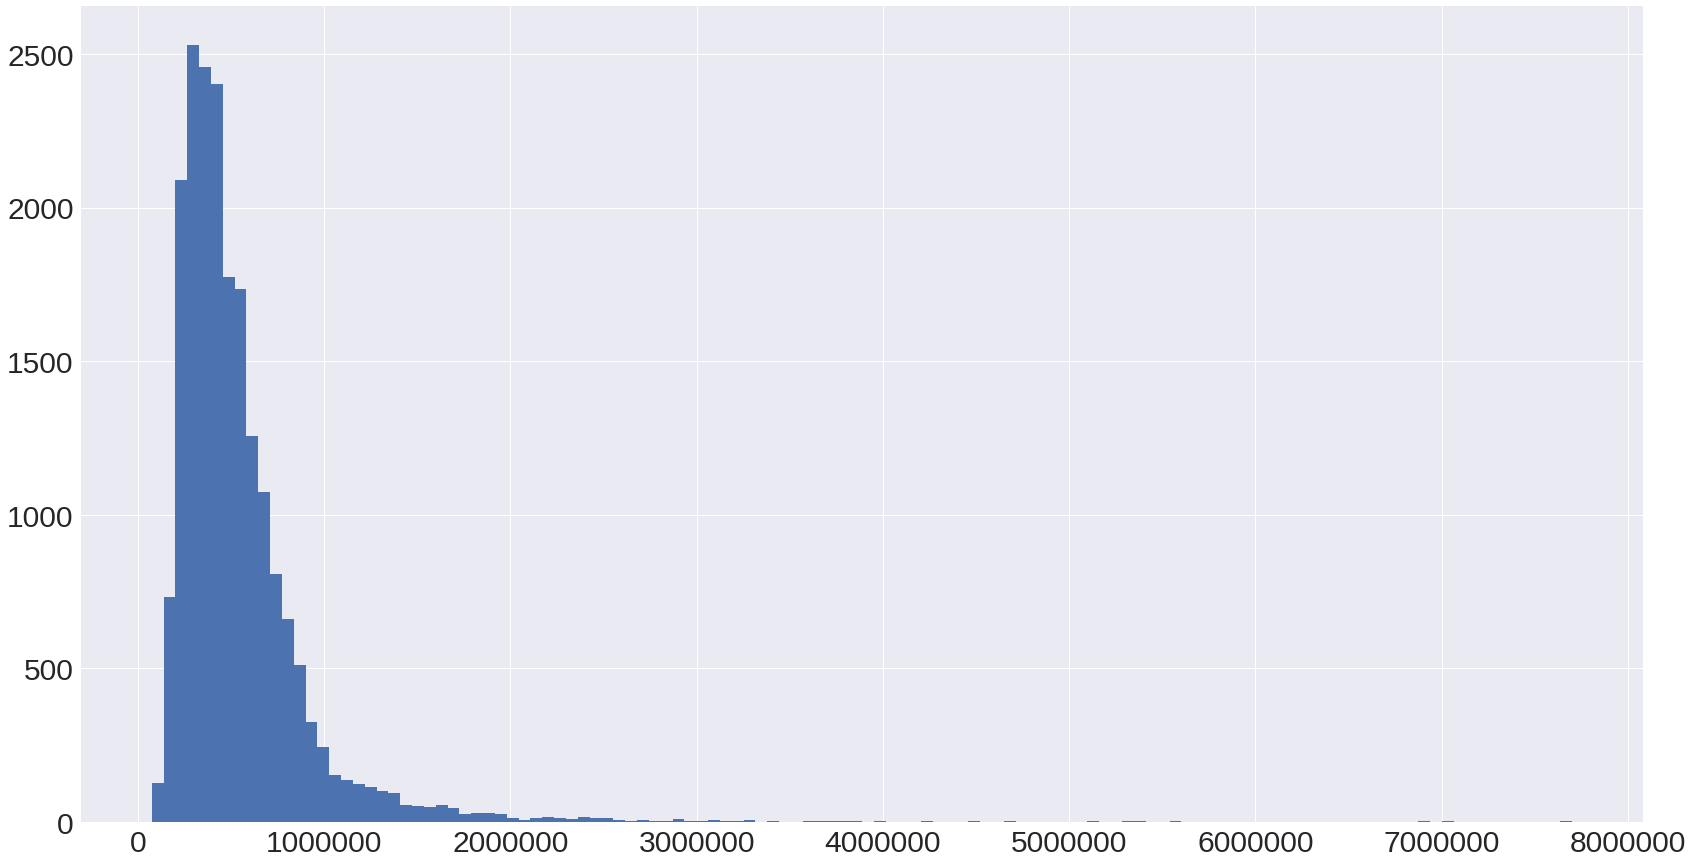

In [101]:
y_train_df.hist(xlabelsize=30, ylabelsize=30, bins=120,figsize=(28,15))

In [102]:
y_train_df.describe()

count    2.000000e+04
mean     5.354737e+05
std      3.659484e+05
min      7.500000e+04
25%      3.170000e+05
50%      4.499500e+05
75%      6.400000e+05
max      7.700000e+06
Name: price, dtype: float64

In [103]:
(y_train_df>640000).sum()

4962

75% of the house prices are in the range between 0 and 640000

From the table, we can see the descriptive statistics of training data 

# Skewness

[skewness](https://whatis.techtarget.com/definition/skewness)

The skewness should be about zero for normal distribution. 

A skenewss  value greater than zero means that there is more weight in the left tail of the distribution

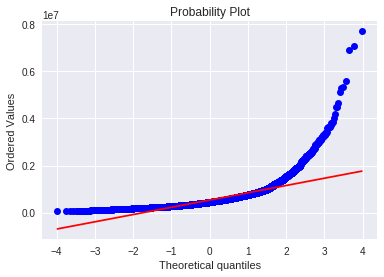

Skewness: 4.118


In [104]:
plt.figure()
qq = stats.probplot(y_train_df, plot=plt)
plt.show()

print("Skewness: {:.3f}".format(y_train_df.skew()))

Our data has a positive skewness. There is more weight in the left tail of the price distribution

Next, we take a log of price column and see what happens!

# Transformation of price

Check the skewness and apply log transformation

Skewness: 0.419


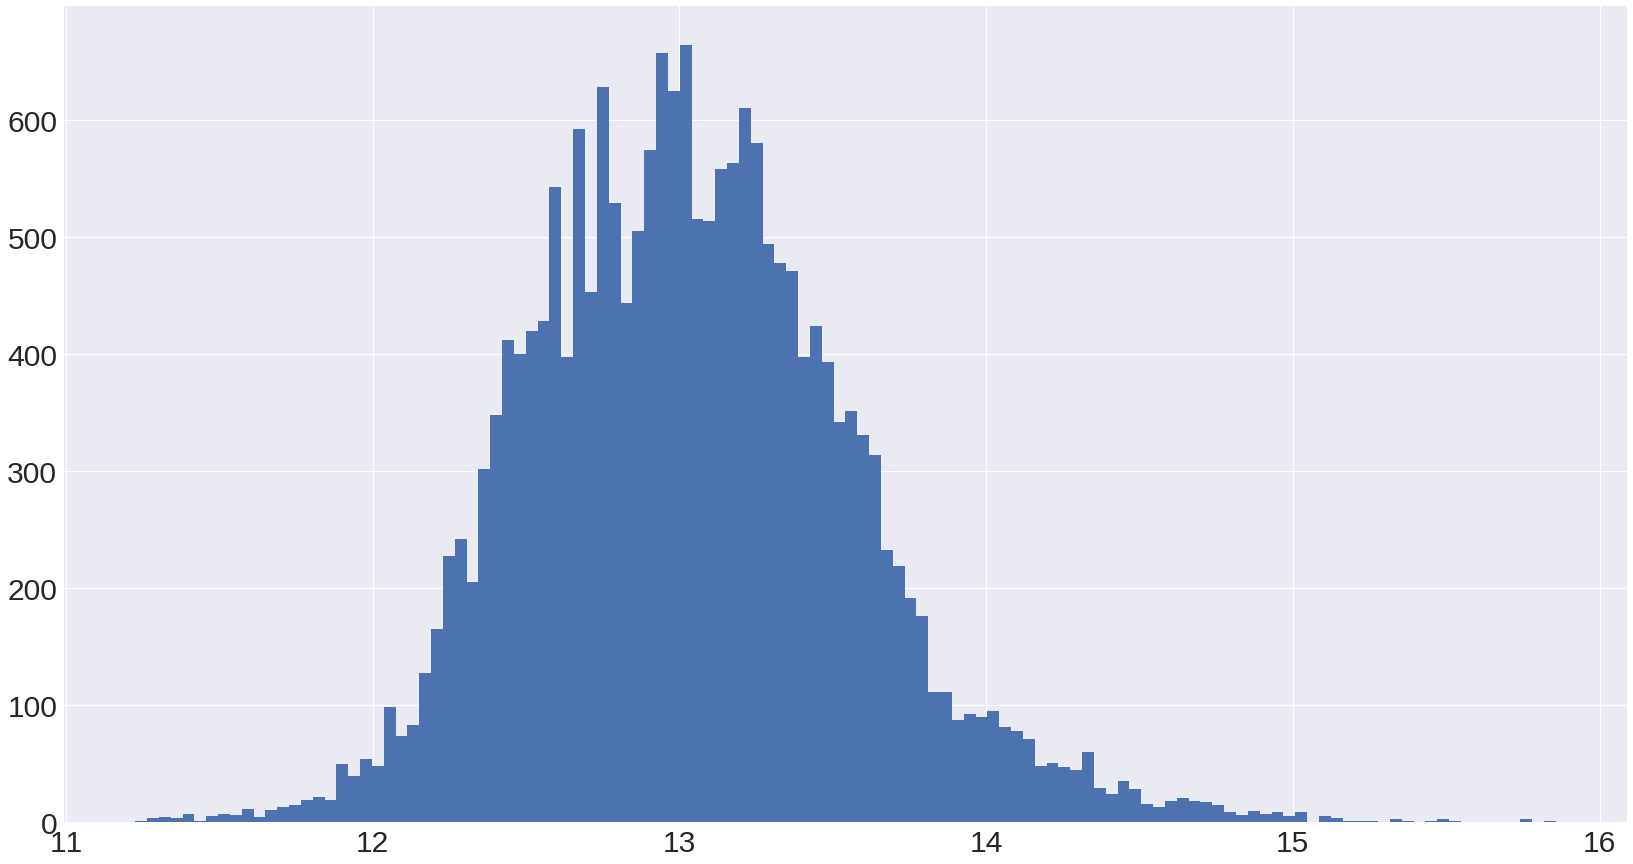

In [105]:
y_train_df = np.log1p(y_train_df)
y_test_df = np.log1p(y_test_df)

y_train_df.hist(xlabelsize=30, ylabelsize=30, bins=120,figsize=(28,15))


print("Skewness: {:.3f}".format(y_train_df.skew()))

The distribution is more like a normal distribution than before!


# Q-Q Plot

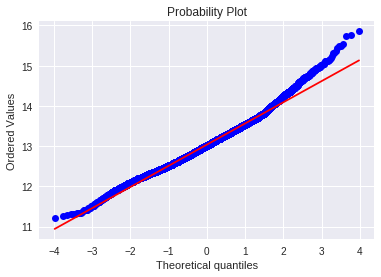

In [106]:
plt.figure()
qq = stats.probplot(y_train_df, plot=plt)
plt.show()

By taking a log of price column, it is close to normal distribution

# Parameter Tuning 

For each model, I will use grid search to find a good combination of hyper-parameters.


# GBM

In [0]:
y_train = y_train_df.values
y_test = y_test_df.values
X_train = X_train_df.values
X_test = X_test_df.values

In [0]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn import ensemble
from sklearn import datasets
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold 

In [0]:
params = {'loss': 'ls',
         'learning_rate': 0.001,
         'n_estimators': 3000,
         "subsample":0.9,
         'max_depth': 5, 
         'min_samples_split': 2}

gb_reg = ensemble.GradientBoostingRegressor(**params)

max_depth represents the depth of each tree in the forest. The deeper the tree, the more splits it has and it captures more information about the data. 

There is no universal rule to determine the best the value of `max_depth`. So we did a grid a serach here to find a good fit.

In [110]:
grid_1 = {"max_depth"         : [5, 7]}
"""
          "learning_rate"      : [0.001,0.006],
          "n_estimators"      : [3000, 5000]}
               
               
               "loss"         : ["lad", "ls"],
               "min_samples_split" : [2, 5] }
"""


grid_search = GridSearchCV(gb_reg, grid_1, n_jobs=4, cv=5,refit=True,scoring="neg_mean_squared_error")
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.001, loss='ls', max_depth=5,
             max_features=None, max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_sam...       subsample=0.9, tol=0.0001, validation_fraction=0.1, verbose=0,
             warm_start=False),
       fit_params=None, iid='warn', n_jobs=4,
       param_grid={'max_depth': [5, 7]}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [111]:
params = grid_search.best_params_

print('Best params:{}'.format(params))
print('Result of each iteration:{}'.format(grid_search.cv_results_))
print('best score:{}'.format(grid_search.best_score_))

Best params:{'max_depth': 7}
Result of each iteration:{'mean_fit_time': array([387.47166095, 648.15375247]), 'std_fit_time': array([  9.12478398, 186.9979244 ]), 'mean_score_time': array([1.20596089, 1.34992032]), 'std_score_time': array([0.01289685, 0.49182487]), 'param_max_depth': masked_array(data=[5, 7],
             mask=[False, False],
       fill_value='?',
            dtype=object), 'params': [{'max_depth': 5}, {'max_depth': 7}], 'split0_test_score': array([-0.03638707, -0.03167887]), 'split1_test_score': array([-0.03575163, -0.03086882]), 'split2_test_score': array([-0.03564735, -0.03094102]), 'split3_test_score': array([-0.03786243, -0.03272178]), 'split4_test_score': array([-0.03602916, -0.03099553]), 'mean_test_score': array([-0.03633553, -0.0314412 ]), 'std_test_score': array([0.00080529, 0.00070325]), 'rank_test_score': array([2, 1], dtype=int32), 'split0_train_score': array([-0.03216381, -0.02247652]), 'split1_train_score': array([-0.03237427, -0.02259809]), 'split2_trai

In [112]:
gb_reg.set_params(**params)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.001, loss='ls', max_depth=7,
             max_features=None, max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=3000,
             n_iter_no_change=None, presort='auto', random_state=None,
             subsample=0.9, tol=0.0001, validation_fraction=0.1, verbose=0,
             warm_start=False)

The grid search shows that `max_depth` of 7 is better than 5


In [114]:
gb_reg.fit(X_train, y_train)
y_pred = gb_reg.predict(X_test)
print("MSE: {0:.5f}".format(mean_squared_error(y_test, y_pred)))
print("R2: {0:.5f}".format(r2_score(y_test, y_pred)))

MSE: 0.02445
R2: 0.89328


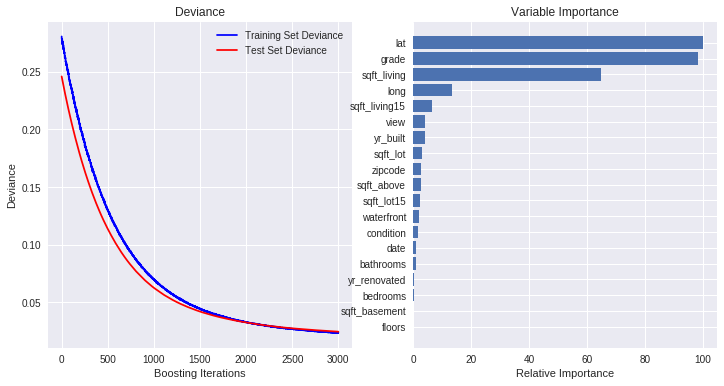

In [115]:
# #############################################################################
# Plot training deviance

# compute test set deviance
test_score = np.zeros((gb_reg.get_params()['n_estimators'],), dtype=np.float64)

for i, y_pred in enumerate(gb_reg.staged_predict(X_test)):
    test_score[i] = gb_reg.loss_(y_test, y_pred)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('Deviance')
plt.plot(np.arange(gb_reg.get_params()['n_estimators']) + 1, gb_reg.train_score_, 'b-',
         label='Training Set Deviance')
plt.plot(np.arange(gb_reg.get_params()['n_estimators']) + 1, test_score, 'r-',
         label='Test Set Deviance')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Deviance')

# #############################################################################
# Plot feature importance
feature_importance = gb_reg.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X_train_df.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

# Random Forest

In [0]:
from sklearn.ensemble import RandomForestRegressor

params = {'n_estimators': 700, 'max_depth': 8, 'min_samples_split': 2}

rf_reg = RandomForestRegressor(**params)



From sk-learn the documentation:

[max_features] is the size of the random subsets of features to consider when splitting a node.

So max_features is what you call m. When max_features="auto", m = p and no feature subset selection is performed in the trees, so the "random forest" is actually a bagged ensemble of ordinary regression trees. The docs go on to say that

Empirical good default values are max_features=n_features for regression problems, and max_features=sqrt(n_features) for classification tasks

By setting max_features differently, you'll get a "true" random forest





There is no universal way to determine the best the value of `n_estimators`. So we did a grid a serach here to find a good fit.



> Is a random forest even still random if bootstrapping is turned off?

Yes, it's still random. Without bootstrapping, all of the data is used to fit the model, so there is not random variation among the samples at each stage. However, random forest has a second source of variation, which is the random subset of features to try at each split.

I thought the whole premise of a random forest is that, unlike a single decision tree (which sees the entire dataset as it grows), RF randomly partitions the original dataset and divies the partitions up among several decision trees.

This is incorrect. Random forest bootstraps the data for each tree, and then grows a decision tree that can only use a random subset of samples at each split. The documentation states "The sub-sample size is always the same as the original input sample size but the samples are drawn with replacement if bootstrap=True (default)," which implies that bootstrap=False draws a sample of size equal to the number of training examples without replacement, i.e. the same training set is always used.



There is no universal rule to determine the best the value of `bootstrap`. So we did a grid a serach here to find a good fit.

In [117]:
grid_rf = {"bootstrap"         : [True, False]}
"""
          "max_featues"      : [2,6],
          "n_estimators"      : [3000, 5000]}
}
"""


grid_search = GridSearchCV(rf_reg, grid_rf, n_jobs=4, cv=5,refit=True,scoring="neg_mean_squared_error")
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=8,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=700, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=4,
       param_grid={'bootstrap': [True, False]}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [118]:
params = grid_search.best_params_

print('Best params:{}'.format(params))
print('Result of each iteration:{}'.format(grid_search.cv_results_))
print('best score:{}'.format(grid_search.best_score_))

Best params:{'bootstrap': True}
Result of each iteration:{'mean_fit_time': array([141.0289125 , 178.42759027]), 'std_fit_time': array([ 2.34547477, 48.33839469]), 'mean_score_time': array([0.70138121, 0.5187891 ]), 'std_score_time': array([0.02049702, 0.19189417]), 'param_bootstrap': masked_array(data=[True, False],
             mask=[False, False],
       fill_value='?',
            dtype=object), 'params': [{'bootstrap': True}, {'bootstrap': False}], 'split0_test_score': array([-0.03919126, -0.05157522]), 'split1_test_score': array([-0.03850304, -0.0515497 ]), 'split2_test_score': array([-0.03860714, -0.05110219]), 'split3_test_score': array([-0.04088283, -0.05327096]), 'split4_test_score': array([-0.03755336, -0.05054348]), 'mean_test_score': array([-0.03894753, -0.05160831]), 'std_test_score': array([0.00110109, 0.00091203]), 'rank_test_score': array([1, 2], dtype=int32), 'split0_train_score': array([-0.03157038, -0.0413568 ]), 'split1_train_score': array([-0.03112732, -0.04171677]

Minimum sum of instance weight (hessian) needed in a child. If the tree partition step results in a leaf node with the sum of instance weight less than min_child_weight, then the building process will give up further partitioning.

The grid search result shows that `bootstrap` of True is better than False

In [119]:
rf_reg.set_params(**params)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=8,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=700, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [120]:

rf_reg.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=8,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=700, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [121]:

y_pred = rf_reg.predict(X_test)
print("MSE: {0:.5f}".format(mean_squared_error(y_test, y_pred)))
print("R2: {0:.5f}".format(r2_score(y_test, y_pred)))

MSE: 0.03093
R2: 0.86501


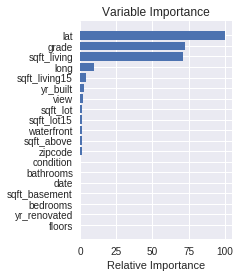

In [122]:
# #############################################################################
# Plot feature importance
feature_importance = rf_reg.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X_train_df.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()


# XGBoost


In [0]:
import xgboost as xgb

## XGBoost train and prediction

In [0]:
xgb_reg = xgb.XGBRegressor(colsample_bytree=0.4,
                 gamma=0,                 
                 learning_rate=0.07,
                 max_depth=6,
                 min_child_weight=1.5,
                 n_estimators=10000,                                                                    
                 reg_alpha=0.75,
                 reg_lambda=0.45,
                 subsample=0.6,
                 seed=42)


For a regression, the loss of each point in a node is

$\frac{1}{2}(y_i - \hat{y_i})^2$

The second derivative of this expression with respect to yi^ is 1. So when you sum the second derivative over all points in the node, you get the number of points in the node. Here, min_child_weight means something like "stop trying to split once your sample size in a node goes below a given threshold".

For a binary logistic regression, the hessian for each point in a node is going to contain terms like

$\sigma(\hat{y_i})(1 - \sigma(\hat{y_i}))$

where σ is the sigmoid function. Say you're at a pure node (e.g., all of the training examples in the node are 1's). Then all of the yi^'s will probably be large positive numbers, so all of the σ(yi^)'s will be near 1, so all of the hessian terms will be near 0. Similar logic holds if all of the training examples in the node are 0. Here, min_child_weight means something like "stop trying to split once you reach a certain degree of purity in a node and your model can fit it".

The Hessian's a sane thing to use for regularization and limiting tree depth. For regression, it's easy to see how you might overfit if you're always splitting down to nodes with, say, just 1 observation. Similarly, for classification, it's easy to see how you might overfit if you insist on splitting until each node is pure.


There is no universal rule to determine the best the value of `min_child_weight`. So we did a grid a serach here to find a good fit.


In [125]:
grid_xgb = {"min_child_weight"         : [1.5, 2]}
"""
          "learning_rate"      : [0.001,0.006],
          "n_estimators"      : [3000, 5000]}
}
"""


grid_search = GridSearchCV(xgb_reg, grid_xgb, n_jobs=4, cv=5,refit=True,scoring="neg_mean_squared_error")
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.4, gamma=0, learning_rate=0.07, max_delta_step=0,
       max_depth=6, min_child_weight=1.5, missing=None, n_estimators=10000,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0.75, reg_lambda=0.45, scale_pos_weight=1, seed=42,
       silent=True, subsample=0.6),
       fit_params=None, iid='warn', n_jobs=4,
       param_grid={'min_child_weight': [1.5, 2]}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [126]:
params = grid_search.best_params_

print('Best params:{}'.format(params))
print('Result of each iteration:{}'.format(grid_search.cv_results_))
print('best score:{}'.format(grid_search.best_score_))

Best params:{'min_child_weight': 1.5}
Result of each iteration:{'mean_fit_time': array([401.48338981, 323.14113417]), 'std_fit_time': array([ 2.31407449, 96.82132712]), 'mean_score_time': array([23.30120249, 17.22437797]), 'std_score_time': array([0.6072591, 7.5860632]), 'param_min_child_weight': masked_array(data=[1.5, 2],
             mask=[False, False],
       fill_value='?',
            dtype=object), 'params': [{'min_child_weight': 1.5}, {'min_child_weight': 2}], 'split0_test_score': array([-0.02798198, -0.02798198]), 'split1_test_score': array([-0.02727022, -0.02727022]), 'split2_test_score': array([-0.0261907, -0.0261907]), 'split3_test_score': array([-0.02886015, -0.02886015]), 'split4_test_score': array([-0.02678609, -0.02678609]), 'mean_test_score': array([-0.02741783, -0.02741783]), 'std_test_score': array([0.00093009, 0.00093009]), 'rank_test_score': array([1, 1], dtype=int32), 'split0_train_score': array([-0.00121792, -0.00121792]), 'split1_train_score': array([-0.0012297

Minimum sum of instance weight (hessian) needed in a child. If the tree partition step results in a leaf node with the sum of instance weight less than min_child_weight, then the building process will give up further partitioning.

The grid search result shows that `min_child_weight` of 1.5 is better than 2

In [127]:
xgb_reg.set_params(**params)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.4, gamma=0, learning_rate=0.07, max_delta_step=0,
       max_depth=6, min_child_weight=1.5, missing=None, n_estimators=10000,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0.75, reg_lambda=0.45, scale_pos_weight=1, seed=42,
       silent=True, subsample=0.6)

In [128]:
xgb_reg.fit(X_train, y_train)
y_pred = xgb_reg.predict(X_test)
print("MSE: {0:.5f}".format(mean_squared_error(y_test, y_pred)))
print("R2: {0:.5f}".format(r2_score(y_test, y_pred)))

MSE: 0.01627
R2: 0.92901


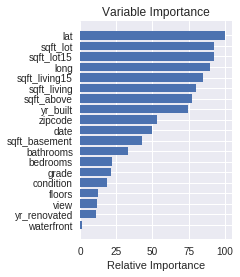

In [129]:
# #############################################################################
# Plot feature importance
feature_importance = xgb_reg.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X_train_df.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()


I choose mean squared error and R square score for evalution.

Here is the comparison table:

|Model| MSE | R2 |
| --- | --- | --- |
| GBM | 0.02418 | 0.89450 |
| Random Forest | 0.03097 | 0.86484 |
| Xgboost | 0.01627 | 0.92901 |



We can see that XGBoost model outperform other models in terms of both MSE and R2



Ref:


[Using Random Forests in Python with Scikit-Learn](https://www.blopig.com/blog/2017/07/using-random-forests-in-python-with-scikit-learn/)


[Explanation of min_child_weight in xgboost algorithm](https://stats.stackexchange.com/questions/317073/explanation-of-min-child-weight-in-xgboost-algorithm)



[What happens when bootstrapping isn't used in sklearn.RandomForestClassifier?](https://stats.stackexchange.com/questions/354336/what-happens-when-bootstrapping-isnt-used-in-sklearn-randomforestclassifier)

Ignore the following



# Hyperopt

In [0]:
from hyperopt import fmin, tpe, hp, partial



In [0]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1, random_state=10)

# dtrain = xgb.DMatrix(X_train, label=y_train)

# dvalid = xgb.DMatrix(X_valid, label=y_valid)

evallist = [(X_valid, y_valid)]

### Model Factory 


In [0]:
def xgboost_factory(argsDict):
    argsDict = argsDict_tranform(argsDict)
    
    params = {'nthread': -1,   
              'max_depth': argsDict['max_depth'],  
              'n_estimators': argsDict['n_estimators'], 
              'eta': argsDict['learning_rate'],  
              'subsample': argsDict['subsample'],   
              'min_child_weight': argsDict['min_child_weight'], 
              'objective': 'reg:linear',
              'silent': 0,  
              'gamma': 0,  
              'colsample_bytree': 0.7,  
              'alpha': 0,   
              'lambda': 0, 
              'scale_pos_weight': 0, 
              'seed': 100,  
              'missing': -999, 
              }
    
    xgb_reg = xgb.XGBRegressor(**params)
    
    xrf = xgb_reg.fit(X_train, y_train, eval_set=evallist, eval_metric='rmse', early_stopping_rounds=100)

    return get_tranformer_score(xrf)

def get_tranformer_score(tranformer):
    
    xrf = tranformer

    prediction = xrf.predict(X_test, ntree_limit=xrf.best_ntree_limit)
  
    return mean_squared_error(y_test, prediction)


## Hyperopt

In [133]:
algo = partial(tpe.suggest, n_startup_jobs=1)
best = fmin(xgboost_factory, space, algo=algo, max_evals=20, pass_expr_memo_ctrl=None)

NameError: ignored

In [0]:
RMSE = xgboost_factory(best)
print('best :', best)
print('best param after transform :')
argsDict_tranform(best,isPrint=True)
print('rmse of the best xgboost:', np.sqrt(RMSE))
